In [1]:
## Notebook that generates supplementary Figure 3 a in Ori et al., 2020
## Clusters the transcriptome at high resolution and correlates their mean expression to EOMES expression levels
## It is based on Definite Endoderm subset generated in generate_subsets.ipynb

## Following Table is generated:
#  Suppl_Table_9_DE_gene_correlation.xlsx

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

## Ignore SpearmanRConstantInputWarning
import warnings
warnings.filterwarnings("ignore")

from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

### Read in subset for Definite Endoderm stage (day 0 to day 6)

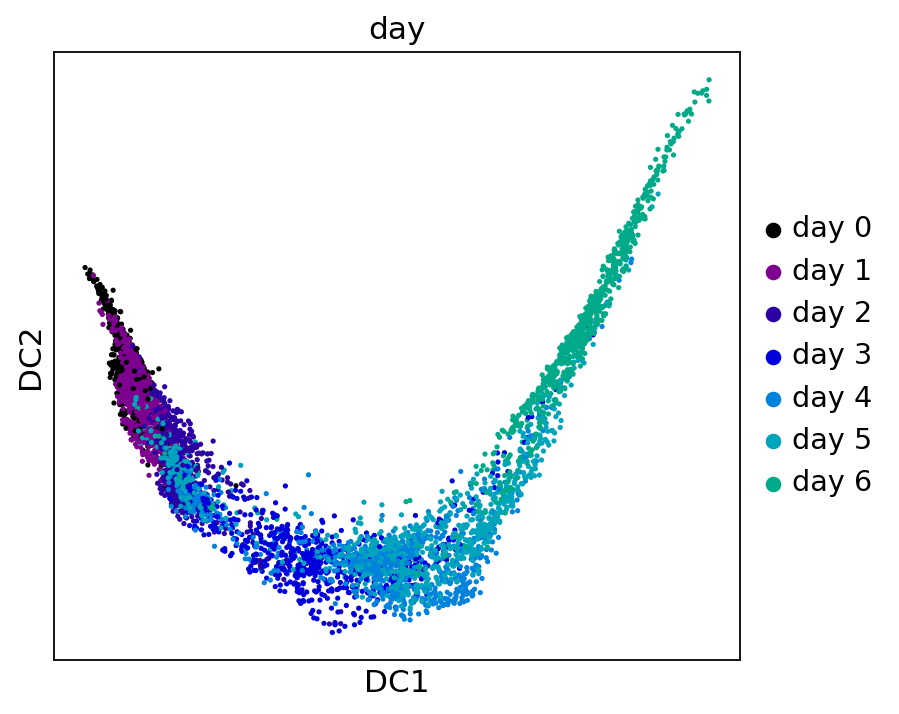

In [2]:
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (5.5, 5)

folder = "/20200806_Drukker_IPSlungProgenitors_meshal.ansari/"
de = sc.read(folder + "IPS_lung_differentiation_defendo.h5ad")
sc.pl.diffmap(de, color = ["day"])

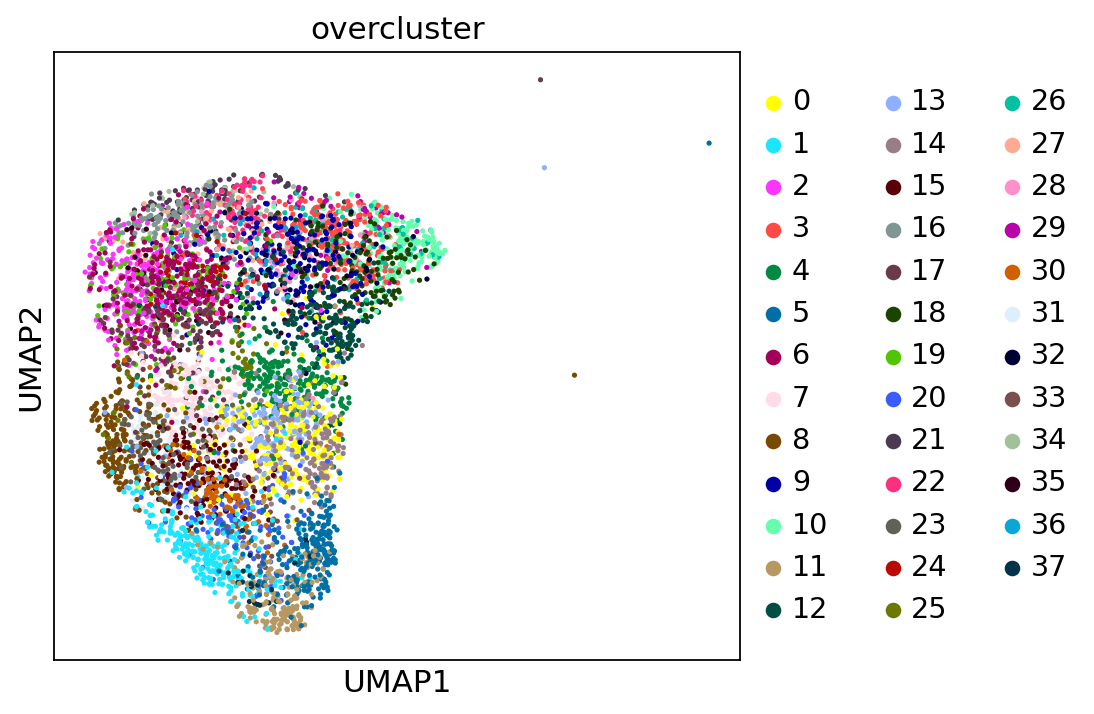

In [4]:
## Re-cluster at higher resolution using louvain
sc.pp.pca(de)
sc.pp.neighbors(de, n_pcs = 20, n_neighbors = 10)
sc.tl.louvain(de, resolution = 5, key_added = "overcluster")
sc.pl.umap(de, color = "overcluster")

### Define Functions

In [5]:
import scipy.stats

def generate_expr_table(adata, xlabel = "day"):
    genExp = pd.DataFrame(adata.raw.X.todense(), index = adata.obs_names, columns = adata.raw.var_names)
    genExp[xlabel] = adata.obs[xlabel]
    return genExp

def correlate_means_to_gene(means, corr_gene = "EOMES"):
    genes = means.columns.values
    cors = pd.DataFrame(index = genes, columns = ["spearman_corr", "pvalue"])
    tab = means.loc[:, [corr_gene]].values

    for gene in genes:
        tmp = scipy.stats.spearmanr(tab, means.loc[:, [gene]])   # Spearman's rho    
        cors.loc[gene, :] = tmp[0:2]

    ## Throw away NA columns
    cors.dropna(axis = 0, inplace = True)
    cors.sort_values("spearman_corr", ascending = False, inplace = True)
    return cors

## R Heatmap Plotting
def plot_gene_corr(means, cors, corr_gene = "NOTUM", norbmt = None, top = 50):
    cors = cors[cors.pvalue < 0.05].copy()
    genes = cors.index.values
    
    if norbmt:
        ## Exclude ribosomal / mitochondrial genes from differential gene expression table
        rbmt_genes = [name for name in genes if name.startswith('RP') | name.startswith('MT-') | name.startswith('Rp')]
        cors = cors[~cors.index.isin(rbmt_genes)]

    ## Exclude correlation gene from list to plot
    top = int(top/2)
    genes = np.concatenate((cors.index.values[1:(top + 1)], cors.index.values[-top:]))
    corr_gene_expr = means.loc[:, corr_gene].T.copy()
    corr_gene_expr.sort_values(inplace = True)

    means_plot = means.loc[:, genes].T
    means_plot = means_plot.loc[:, corr_gene_expr.index.values]
    print(means_plot.shape)
    
    %R -i corr_gene names(gene_col) <- corr_gene    
    %R -i genes -i corr_gene_expr -i means_plot -i top anno_row <- data.frame(sign = c(rep("pos", top), rep("neg", top)))
    %R rownames(anno_row) <- genes
    %R anno_col <- data.frame(gene = corr_gene_expr)
    %R colnames(anno_col) <- corr_gene
    %R rownames(anno_col) <- colnames(means_plot)

    %R -w 800 -h 600 p <- pheatmap(means_plot, scale = 'row', cluster_cols = F, show_colnames = F, \
                                                 col = color, annotation_row = anno_row, annotation_col = anno_col, \
                                                 breaks = seq(-2, 2, length = 100), annotation_colors = gene_col, \
                                                 main = paste("Correlation to", corr_gene))

In [10]:
%%R
library(pheatmap)

## Set colours
color = colorRampPalette(c("deepskyblue3", "white", "red3"))(100)
gene_col = list(gene = c("white", "red3"))

### Calculate cluster-wise Correlation to EOMES

In [6]:
corr_gene = "EOMES"
genExp = generate_expr_table(de, xlabel = "overcluster")

## Calculate Mean expression per Cluster
meanExp = genExp.groupby(["overcluster"]).mean().reset_index()
meanExp.set_index("overcluster", inplace = True)
meanExp.iloc[:3, :10]

index,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADACL3,AADAT
overcluster,,,,,,,,,,
0,0.009673,0.007840,0.0,0.0,0.000000,0.014833,0.037107,0.030797,0.0,0.071403
1,0.000000,0.009184,0.0,0.0,0.029808,0.010614,0.039764,0.126524,0.0,0.152280
2,0.000000,0.018711,0.0,0.0,0.000000,0.000000,0.026249,0.093141,0.0,0.055219


In [7]:
cors = correlate_means_to_gene(meanExp, corr_gene = corr_gene)

## Genes that are expected to be correlated with EOMES
exp_genes = ["EOMES", "LHX1", "FOXA2", "CXCR4", "LEFTY1", "GATA6", "OTX2", "GSC", "NODAL"]
cors.loc[exp_genes]

,spearman_corr,pvalue
EOMES,1,0
LHX1,0.785859,5.06367e-09
FOXA2,0.832815,8.89163e-11
CXCR4,0.869633,1.3882e-12
LEFTY1,0.834535,7.49268e-11
GATA6,0.83816,5.19012e-11
OTX2,0.728464,2.16546e-07
GSC,0.746307,7.49702e-08
NODAL,0.729701,2.01723e-07


(50, 38)


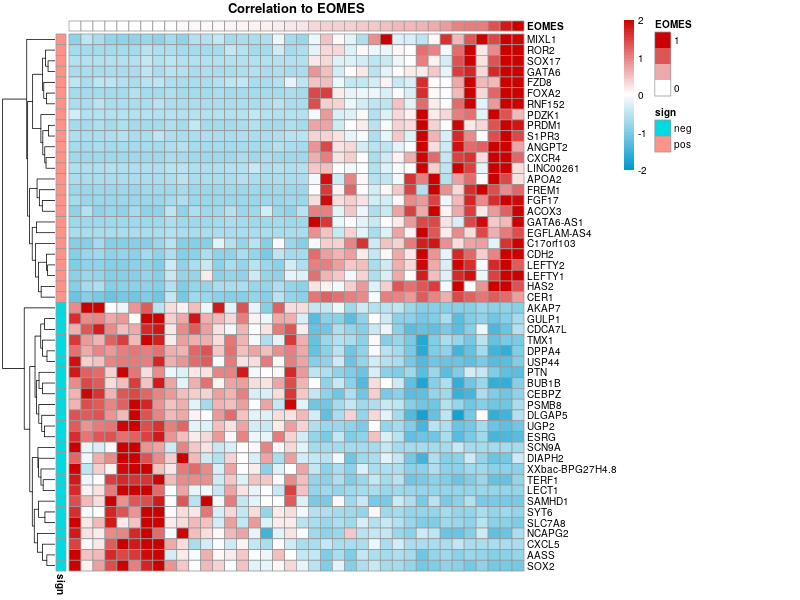

In [12]:
plot_gene_corr(meanExp, cors, corr_gene = corr_gene, norbmt = True, top = 50)

(100, 38)


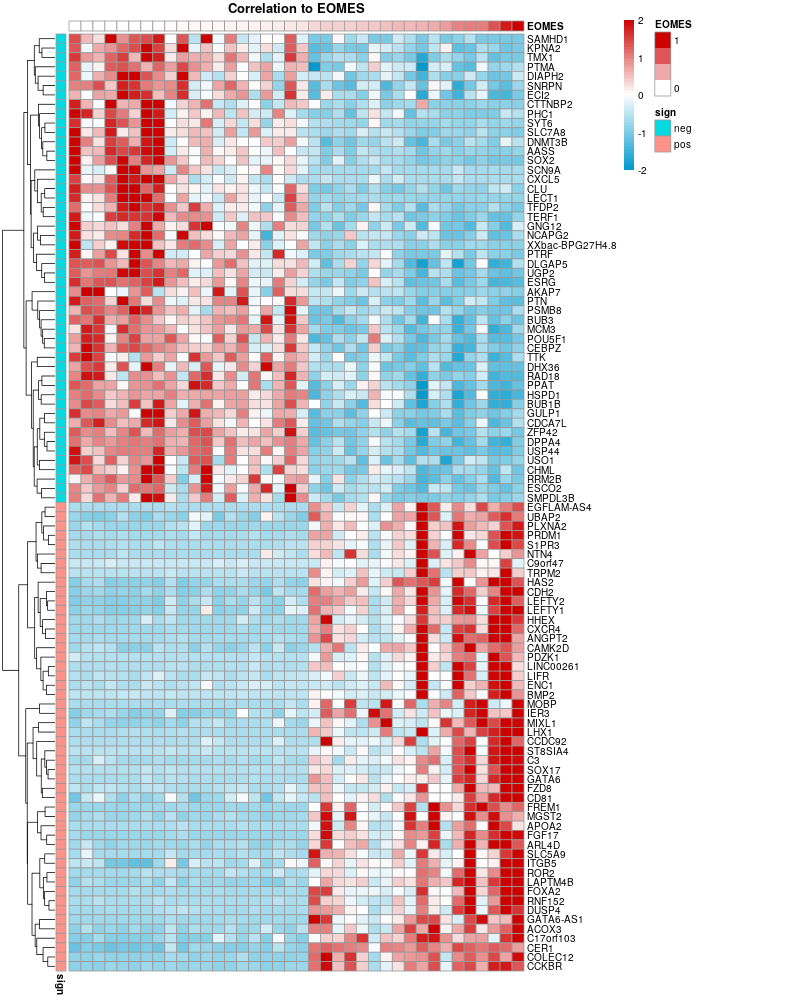

In [13]:
## Also plot top 50 correlated and anti-correlated genes to EOMES
plot_gene_corr(meanExp, cors, corr_gene = corr_gene, norbmt = True, top = 100)